<a href="https://colab.research.google.com/github/firaaliah/202055202088-firaaliah/blob/master/DL_Klasifikasi_Jenis_Tas_M6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"firaaliah","key":"e8e33faacc1fb030c1d5b7bad46c5782"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 May  9 12:17 kaggle.json


In [4]:
!pip install -q kaggle

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d firaaliah/deep-learning-klasifikasi-jenis-tas

 67% 34.0M/50.4M [00:00<00:00, 90.2MB/s]
100% 50.4M/50.4M [00:00<00:00, 99.6MB/s]


In [7]:
!unzip deep-learning-klasifikasi-jenis-tas.zip

Archive:  deep-learning-klasifikasi-jenis-tas.zip
  inflating: Jenis Tas/tas backpack/080fcbd62cda7ede54bc3c6b78a2fa5b.jpg  
  inflating: Jenis Tas/tas backpack/09932f055e2f2363f01bae1d7c2acbe4.jpg  
  inflating: Jenis Tas/tas backpack/09fdaf4bc954a5abdff731c1b08e96cc.jpg  
  inflating: Jenis Tas/tas backpack/0ac689aa018bc8f55b35e9c877b7a4e1.jpg  
  inflating: Jenis Tas/tas backpack/0ad5b516225d35bb2de3791bff6a4955.jpg  
  inflating: Jenis Tas/tas backpack/0c29094430221df4bde2d132f95c3380.jpg  
  inflating: Jenis Tas/tas backpack/0c60573437ec63a63d90fca5dcfc81dd.jpg  
  inflating: Jenis Tas/tas backpack/0c97a2ce326e3fa7f274efb283884ea6.jpg  
  inflating: Jenis Tas/tas backpack/0e2e5ceea6300d2c6279a61c9d5c161f.jpg  
  inflating: Jenis Tas/tas backpack/0ea4dde823c70e9536c1298180a37309.jpg  
  inflating: Jenis Tas/tas backpack/11828469abd7f3021cae608b31463fbd.jpg  
  inflating: Jenis Tas/tas backpack/11d755699bc84540f99e1130ace942a9.jpg  
  inflating: Jenis Tas/tas backpack/13a683602a9b96

In [8]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [9]:
dataset_path = Path(r'/content/Jenis Tas')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [10]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/Jenis Tas/tas shoulder bag/7b8e439a86...,tas shoulder bag
1,/content/Jenis Tas/tas shoulder bag/levis-wome...,tas shoulder bag
2,/content/Jenis Tas/tas shoulder bag/3218bb2b0f...,tas shoulder bag
3,/content/Jenis Tas/tas shoulder bag/23fa76d35c...,tas shoulder bag
4,/content/Jenis Tas/tas shoulder bag/822b027f60...,tas shoulder bag


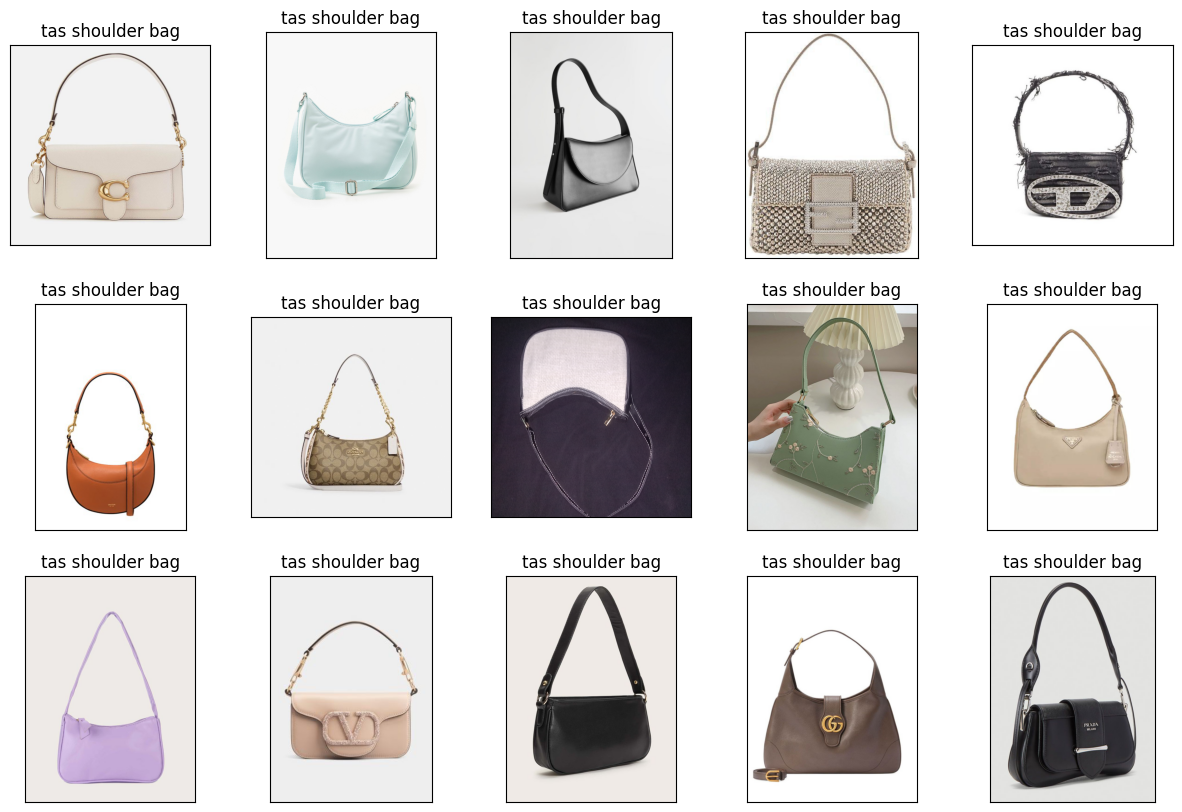

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [12]:
df.label.value_counts()

tas shoulder bag    105
tas totebag         105
tas backpack        103
Name: label, dtype: int64

In [13]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

tas shoulder bag    105
tas totebag         105
tas backpack        103
Name: label, dtype: int64

In [14]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [15]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (175, 2)
Shape of test data (94, 2)
Shape of validation data (44, 2)


In [16]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 175 validated image filenames belonging to 3 classes.
Found 94 validated image filenames belonging to 3 classes.
Found 44 validated image filenames belonging to 3 classes.


In [17]:
input_shape = (200, 200, 3)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [39]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 300, validation_data=val, epochs=5, callbacks=callback)

Epoch 1/5
6/6 [==============================] - 36s 5s/step - loss: 0.7874 - accuracy: 0.6343 - val_loss: 0.7427 - val_accuracy: 0.7045
Epoch 2/5
6/6 [==============================] - 30s 5s/step - loss: 0.7070 - accuracy: 0.7143 - val_loss: 0.7845 - val_accuracy: 0.6818
Epoch 3/5
6/6 [==============================] - 31s 5s/step - loss: 0.7053 - accuracy: 0.6743 - val_loss: 0.8005 - val_accuracy: 0.6364
Epoch 4/5
6/6 [==============================] - 31s 5s/step - loss: 0.6508 - accuracy: 0.7429 - val_loss: 0.6956 - val_accuracy: 0.7045
Epoch 5/5
6/6 [==============================] - 31s 5s/step - loss: 0.6710 - accuracy: 0.7314 - val_loss: 0.6238 - val_accuracy: 0.7727


In [40]:
model.save('model-1.h5')

In [41]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

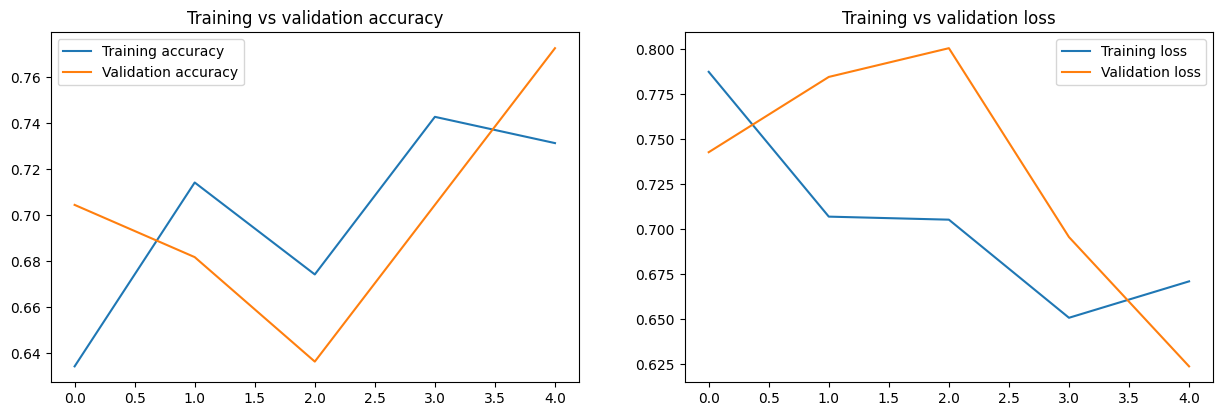

In [42]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [43]:
pred = model.predict(test)

3/3 [==============================] - 5s 1s/step


In [44]:
pred = np.argmax(pred, axis=1)

In [45]:
labels = train.class_indices

In [46]:
labels

{'tas backpack': 0, 'tas shoulder bag': 1, 'tas totebag': 2}

In [47]:
labels = dict((v,k) for k, v in labels.items())

In [48]:
labels

{0: 'tas backpack', 1: 'tas shoulder bag', 2: 'tas totebag'}

In [49]:
y_pred = [labels[k] for k in pred]

In [50]:
print(classification_report(x_test.label, y_pred))

                  precision    recall  f1-score   support

    tas backpack       0.79      0.67      0.72        33
tas shoulder bag       0.74      0.85      0.79        33
     tas totebag       0.61      0.61      0.61        28

        accuracy                           0.71        94
       macro avg       0.71      0.71      0.71        94
    weighted avg       0.72      0.71      0.71        94



In [51]:
print(confusion_matrix(x_test.label, y_pred))

[[22  3  8]
 [ 2 28  3]
 [ 4  7 17]]


In [52]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 7s 2s/step - loss: 0.6933 - accuracy: 0.6809
